In [1]:
import json
import torch
from torchvision import models, transforms
from PIL import Image
import torchvision.transforms.functional as TF
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import torch.nn.functional as F
# dev for scaling

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

def refine_paths(experiment,args):



    path_list = experiment['train']

    def load_image(filename, crop_size=256, aligned=True, img_size=280):
        img = Image.open(filename)
        img = img.convert('RGB')
        
        if aligned:
            img = TF.resize(img, crop_size, Image.BICUBIC)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        else:
            img = TF.resize(img, img_size, Image.BICUBIC)
            angle = transforms.RandomRotation.get_params([-10, 10])
            img = TF.rotate(img, angle, fill=(0,))
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
            img = TF.crop(img, i, j, h, w)
            img = TF.to_tensor(img)
            img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img = img.to(torch.float32)
        return img

    def embedding_concat(x, y):
        B, C1, H1, W1 = x.size()
        _, C2, H2, W2 = y.size()
        s = int(H1 / H2)
        x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
        x = x.view(B, C1, -1, H2, W2)
        z = torch.zeros(B, C1 + C2, x.size(2), H2, W2).to(device)
        for i in range(x.size(2)):
            z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
        z = z.view(B, -1, H2 * W2)
        z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)
        return z

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    featuremaps = []
    backbone = models.resnet18(pretrained=True).to(device)
    backbone.eval()
    outputs = []

    def hook(module, input, output):
        outputs.append(output)

    backbone.layer1[-1].register_forward_hook(hook)
    backbone.layer2[-1].register_forward_hook(hook)
    backbone.layer3[-1].register_forward_hook(hook)

    img_list = [load_image(path, aligned=False) for path in path_list]

    with torch.no_grad():
        for img in img_list:
            img = img.unsqueeze(0).to(device)
            outputs = []
            _ = backbone(img)
            outputs = embedding_concat(embedding_concat(outputs[0], outputs[1]), outputs[2])
            featuremaps.append(outputs.cpu().numpy())


    shuffled_final = np.array(featuremaps).squeeze()

    isolation_outliers = []
    lof_outliers = []

    for i in range(shuffled_final.shape[1]):
        feature_maps = shuffled_final[:, i, :, :]
        flattened_feature_maps = feature_maps.reshape(feature_maps.shape[0], -1)

        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(flattened_feature_maps)

        clf_isolation = IsolationForest(contamination=args.assumed_contamination_rate)
        outliers_isolation = clf_isolation.fit_predict(features_scaled)
        isolation_outliers.append(outliers_isolation)

        clf_lof = LocalOutlierFactor(n_neighbors=20, contamination=args.assumed_contamination_rate)
        outliers_lof = clf_lof.fit_predict(features_scaled)
        lof_outliers.append(outliers_lof)

    isolation_outliers = np.array(isolation_outliers)
    lof_outliers = np.array(lof_outliers)

    isolation_column_sums = isolation_outliers.sum(axis=0)
    lof_column_sums = lof_outliers.sum(axis=0)


    remove_inds=np.array(lof_column_sums).argsort()[:int(args.assumed_contamination_rate * len(lof_column_sums))]
    selected_paths = [path_list[i] for i in remove_inds]
    refined_paths= [path for path in path_list if path not in selected_paths]

    experiment['isoforest_scores'] = isolation_column_sums.tolist()
    experiment['lof_scores'] = lof_column_sums.tolist()
    experiment['lof_refined_paths'] = refined_paths

    return experiment

    # with open(experiment_path, 'w') as file:
    #     json.dump(experiment, file)
        


def precision_recall(distance_metric: list, groundtruth: list, quantiles: float = 0.001, thresh_larger: bool = False) -> tuple:
    """
    Calculates precision and recall for a given distance metric.
    params: 
        distance_metric: list of distance metric values
        groundtruth: list of groundtruth labels
        quantiles: number of quantiles to calculate precision and recall
        thresh_larger: if True, then the larger the distance_metric the more likely it's a normal sample
    returns: 
        tuple of precision and recall
    """
    quantile_list = np.arange(0, 1, quantiles)
    precision, recall = [], []
    for quantile in quantile_list:
        thresh = np.quantile(distance_metric, quantile)
        predict = np.zeros_like(distance_metric)  # predictions are all normals
        if thresh_larger:
            idxs = np.where(np.array(distance_metric) <= thresh)[0]  # all anomalies
        else:
            idxs = np.where(np.array(distance_metric) >= thresh)[0]  # all anomalies

        predict[idxs] = 1
        tn, fp, fn, tp = confusion_matrix(groundtruth, predict).ravel()

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    return precision, recall

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

def precision_recall(distance_metric: list, groundtruth: list, quantiles: float = 0.001, thresh_larger: bool = False) -> tuple:
    """
    Calculates precision and recall for a given distance metric.
    params: 
        distance_metric: list of distance metric values
        groundtruth: list of groundtruth labels
        quantiles: number of quantiles to calculate precision and recall
        thresh_larger: if True, then the larger the distance_metric the more likely it's a normal sample
    returns: 
        tuple of precision and recall
    """
    quantile_list = np.arange(0, 1, quantiles)
    precision, recall = [], []
    for quantile in quantile_list:
        thresh = np.quantile(distance_metric, quantile)
        predict = np.zeros_like(distance_metric)  # predictions are all normals
        if thresh_larger:
            idxs = np.where(np.array(distance_metric) <= thresh)[0]  # all anomalies
        else:
            idxs = np.where(np.array(distance_metric) >= thresh)[0]  # all anomalies

        predict[idxs] = 1
        tn, fp, fn, tp = confusion_matrix(groundtruth, predict).ravel()

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    return precision, recall

def PR_ROC_runs(data_input: dict, category: str):
    plt.figure(figsize=(20, 8))  # Increased figure size for better visibility
    plt.suptitle(f'{category}', y=1.02, fontsize=16)
    
    class_names = []
    data = {}
    
    # Scale all scores in data
    for key in data_input.keys():
        if key not in ['paths', 'gt_labels']:
            # scale the scores from the own approach
            if key in ['own; ISO', 'own; LOF']:
    
                class_names.append(key)
                scaled_runs = []
                runs = data_input[key]
                for run in runs:
                    if not isinstance(run, np.ndarray):
                        run = np.array(run)
                        
                    scaler = MinMaxScaler()
                    scores_scaled = scaler.fit_transform(run.reshape(-1, 1)).flatten()
                    scaled_runs.append(1 - scores_scaled)
                data[key] = np.array(scaled_runs)
            else:
                class_names.append(key)
                data[key] = np.array(data_input[key])    
                
            
    print(class_names)
            

    # colors = [
    #     'skyblue', 'blue',
    #     'lightcoral', 'red',
    #     'lightgray', 'gray',        
    #     'lightgreen', 'green',
    #     'peachpuff', 'orange',
    #     'lightyellow', 'yellow',
    #     'lightpink', 'deeppink',
    #     'thistle', 'purple',
    #     'palegreen', 'limegreen',
    #     'powderblue', 'teal',
    #     'lightsteelblue', 'navy'
    # ]
    colors = ['skyblue', 'blue','lightcoral', 'red','purple', 'black', 'green', 'orange',  'gray','deeppink','peachpuff','lightolive', 'darkolivegreen','palegreen', 'limegreen','powderblue', 'teal','lightsteelblue', 'navy']

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    for class_index, class_name in enumerate(class_names):
        print(class_name)
        scores_list = data[class_name]
        
        # Calculate precision-recall values for each run
        precision_runs = []  # List to store precision values for each run
        recall_runs = [] 
        
        for scores, gt in zip(scores_list, data_input['gt_labels']):
            
            precision, recall = precision_recall(scores, gt)
            precision_runs.append(precision)
            recall_runs.append(recall)

        precision_mean = np.mean(precision_runs, axis=0)
        recall_mean = np.mean(recall_runs, axis=0)
        
        precision_max = np.max(precision_runs, axis=0)
        precision_min = np.min(precision_runs, axis=0)
        pr_auc = auc(recall_mean, precision_mean)

        plt.fill_between(recall_mean, precision_min, precision_max, alpha=0.1, color=colors[class_index])
        plt.plot(recall_mean, precision_mean, label=f'{class_name} AUC {pr_auc:.3f}', color=colors[class_index])

    plt.xlabel('True Positive Rate (Recall)')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Legends below the plot

    # ROC Curve Subplot
    plt.subplot(1, 2, 2)
    for class_index, class_name in enumerate(class_names):
        scores_list = data[class_name]
        
        # Calculate ROC values for each run
        fprs = []
        tprs = []
        roc_aucs = []

        for scores, gt in zip(scores_list, data_input['gt_labels']):
            fpr, tpr, _ = roc_curve(gt, scores)
            #plt.plot(fpr, tpr, color='gray', alpha=0.1)
            
            fprs.append(np.interp(np.linspace(0, 1, 1000), fpr, tpr))  # Interpolating to have the same fpr points
            roc_aucs.append(auc(fpr, tpr))

        fprs = np.array(fprs)

        # Calculate max, min, and median tpr at each fpr point
        tpr_max = np.max(fprs, axis=0)
        tpr_min = np.min(fprs, axis=0)
        tpr_median = np.median(fprs, axis=0)
        fpr_points = np.linspace(0, 1, 1000)
        
        roc_auc = np.mean(roc_aucs)
        plt.fill_between(fpr_points, tpr_min, tpr_max, alpha=0.1, color=colors[class_index])
        plt.plot(fpr_points, tpr_median, label=f'{class_name} AUC: {roc_auc:.3f}', color=colors[class_index])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)  # Legends below the plot

    # Adjust layout to add space between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust the space between subplots

    plt.show()
    
#original

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

def metrics_and_plots(labels, scores1, scores2, scores3, category):
    scores_list = [scores1, scores2, scores3]
    colors = ['blue', 'green', 'red']
    labels_scores = ['Iso-Forest', 'LOF', 'Ensemble']

    plt.figure(figsize=(24, 6))
    plt.suptitle(f'{category}', y=1.02, fontsize=16) 

    # Plot Precision-Recall curves
    plt.subplot(1, 3, 1)
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        precision, recall, _ = precision_recall_curve(labels, 1 - scores_scaled)
        avg_precision = average_precision_score(labels, 1 - scores_scaled)
        plt.plot(recall, precision, marker='.', color=color, label=f'{label} (AP = {avg_precision:.2f})')
    
    plt.xlabel('True Positive Rate (Recall)')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)

    # Plot ROC curves
    plt.subplot(1, 3, 2)
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        fpr, tpr, _ = roc_curve(labels, 1 - scores_scaled)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, marker='.', color=color, label=f'{label} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

    # Plot FNR vs Threshold
    plt.subplot(1, 3, 3)
    
    for scores, color, label in zip(scores_list, colors, labels_scores):
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        
        indsort=scores_scaled.argsort()
        sorted=scores_scaled[indsort]
        sorted_labs=np.array(labels)[indsort]

        fnr_values = []
        fpr_values = []

        # Calculate FNR for each quantile from 1 to 100
        for q in range(0, 102,2):
            threshold = np.percentile(sorted, q)
            predictions = (sorted <= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(1-sorted_labs, 1-predictions).ravel()
            # Calculate FNR
            fnr = fn / (tn+fn) if (tn+fn)> 0 else 0
            fnr_values.append(fnr)
            
            fpr = fp / (tn+fp) if (tn+fp)> 0 else 0
            fpr_values.append(fpr)

        # plt.plot(range(0, 102,2), fnr_values, marker='o',color=color)
        plt.plot(range(0, 102,2), fpr_values, marker='o',color=color)
    plt.title('False Negative Ratio (FNR) by Percentile')
    plt.xlabel('Percentile')
    plt.ylabel('False Negative Ratio (FNR)')
    plt.grid(True)
    plt.show()
        

    # Plot histograms of scaled scores
    plt.figure(figsize=(18, 6))
    plt.suptitle(f'{category}', y=1.02, fontsize=16) 
    for i, (scores, color, label) in enumerate(zip(scores_list, colors, labels_scores)):
        plt.subplot(1, 3, i+1)
        scaler = MinMaxScaler()
        scores_scaled = scaler.fit_transform(scores.reshape(-1, 1)).flatten()
        scores_scaled_0 = scores_scaled[labels == 0]
        scores_scaled_1 = scores_scaled[labels == 1]
        plt.hist(scores_scaled_0, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Normals')
        plt.hist(scores_scaled_1, bins=30, color='green', edgecolor='black', alpha=0.7, label='Anomalies')
        plt.title(f'Distribution of {label}')
        plt.xlabel('Score')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Creating a bar plot for Scores 1, Scores 2, and Scores 3
    plt.figure(figsize=(30, 6))
    x = np.arange(len(scores1))
    width = 0.2

    plt.bar(x - width, scores1, width, label='Iso-Forest', color='blue')
    plt.bar(x, scores2, width, label='LOF', color='green')
    # plt.bar(x + width, scores3, width, label='Ensemble', color='red')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Plot of Scores')
    plt.legend()
    plt.show()
    
def load_image(filename, crop_size=256, aligned=True, img_size=280):
    img = Image.open(filename)
    img = img.convert('RGB')
    
    if aligned:
        img = TF.resize(img, crop_size, Image.BICUBIC)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    else:
        img = TF.resize(img, img_size, Image.BICUBIC)
        angle = transforms.RandomRotation.get_params([-10, 10])
        img = TF.rotate(img, angle, fill=(0,))
        i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(crop_size, crop_size))
        img = TF.crop(img, i, j, h, w)
        img = TF.to_tensor(img)
        img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = img.to(torch.float32)
    return img

def PR_ROC__stats(data_input: dict, category: str):
    class_names = []
    data = {}
    
    # Scale all scores in data
    for key in data_input.keys():
        if key not in ['paths', 'gt_labels']:
            # Scale the scores from the own approach
            if key in ['own; ISO', 'own; LOF']:
                class_names.append(key)
                scaled_runs = []
                runs = data_input[key]
                for run in runs:
                    if not isinstance(run, np.ndarray):
                        run = np.array(run)
                    
                    scaler = MinMaxScaler()
                    scores_scaled = scaler.fit_transform(run.reshape(-1, 1)).flatten()
                    scaled_runs.append(1 - scores_scaled)
                data[key] = np.array(scaled_runs)
            else:
                class_names.append(key)
                data[key] = np.array(data_input[key])
    
    print(class_names)
    
    resdict = {'method': [],  'run': [], 'metric':[],'score':[], 'category': []}
    
    for class_index, class_name in enumerate(class_names):
        print(class_name)
        scores_list = data[class_name]
        
        for run, (scores, gt) in enumerate(zip(scores_list, data_input['gt_labels'])):
            precision, recall, _ = precision_recall_curve(gt, scores)
            pr_auc = auc(recall, precision)
            
            resdict['method'].append(class_name)
            resdict['metric'].append('PRAUC')
            resdict['run'].append(run)
            resdict['score'].append(pr_auc)
            resdict['category'].append(category)
            
            fpr, tpr, _ = roc_curve(gt, scores)
            roc_auc = auc(fpr, tpr)
            
            resdict['method'].append(class_name)
            resdict['metric'].append('ROCAUC')
            resdict['run'].append(run)
            resdict['score'].append(roc_auc)
            resdict['category'].append(category)
    
    return resdict

['own; ISO', 'own; LOF', 'FMAPS; ISO', 'Vit_beans; LOF', 'Vit_beans; Cosine', 'Vit_imagenet; Cosine', 'Vit_imagenet; LOF', 'Vit_imagenet; LOF * own; LOF']
own; ISO
own; LOF
FMAPS; ISO
Vit_beans; LOF
Vit_beans; Cosine
Vit_imagenet; Cosine
Vit_imagenet; LOF
Vit_imagenet; LOF * own; LOF


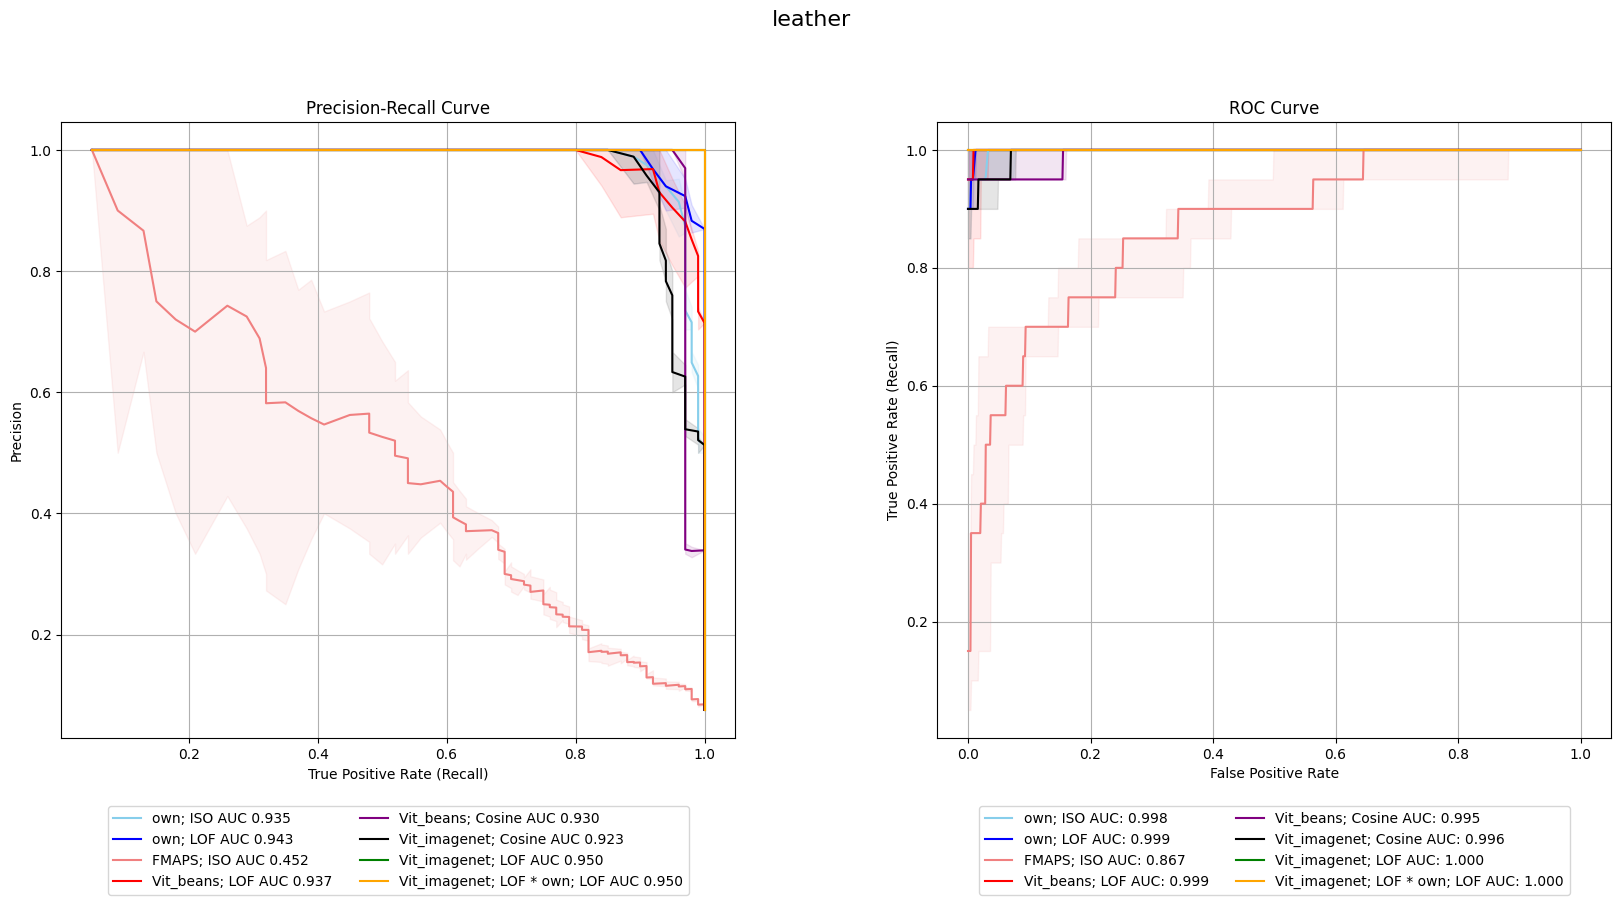

In [14]:

import pickle

category = 'leather'

file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_{category}.pkl'

with open(file_path, 'rb') as file:
    input_= pickle.load(file)


file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_{category}.pkl'
with open(file_path, 'rb') as file:
    input_sota= pickle.load(file)
    
    
    
input_['Vit_beans; Cosine']=input_sota['Vit_beans; Cosine']

input_["Vit_beans; LOF"]=input_sota["Vit_beans; LOF"]




file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_imagenet_{category}.pkl'
with open(file_path, 'rb') as file:
    input_sota_im= pickle.load(file)
input_['Vit_imagenet; Cosine']=input_sota_im['Vit_imagenet; Cosine']
input_["Vit_imagenet; LOF"]=input_sota_im["Vit_imagenet; LOF"]

scaler = MinMaxScaler()
combination_list=[]

for i in range(len(input_['Vit_imagenet; LOF'])):
    
    scores1=input_['Vit_imagenet; LOF'][i]
    score2=np.array(input_['own; LOF'][i])
    scores2 = scaler.fit_transform(score2.reshape(-1, 1)).flatten()
    scores2=np.array(1 - scores2)
    combination_list.append(scores1*scores2)

input_["Vit_imagenet; LOF * own; LOF"] = combination_list



columns_to_remove = ['TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF']

# for ke in input_.keys():
#     print(ke, len(input_[ke]))
#     for elemt in  input_[ke]:
#         print(len(elemt))


for key in columns_to_remove:
    input_.pop(key, None) 

input_.keys()

PR_ROC_runs(data_input=input_, category=category)

['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_beans; LOF', 'Vit_beans; Cosine', 'Vit_imagenet; Cosine', 'Vit_imagenet; LOF', 'Vit_imagenet; LOF * own; LOF']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF
FMAPS; ISO
Vit_beans; LOF
Vit_beans; Cosine
Vit_imagenet; Cosine
Vit_imagenet; LOF
Vit_imagenet; LOF * own; LOF
['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_beans; LOF', 'Vit_beans; Cosine', 'Vit_imagenet; Cosine', 'Vit_imagenet; LOF', 'Vit_imagenet; LOF * own; LOF']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF
FMAPS; ISO
Vit_beans; LOF
Vit_beans; Cosine
Vit_imagenet; Cosine
Vit_imagenet; LOF
Vit_imagenet; LOF * own; LOF
['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_be

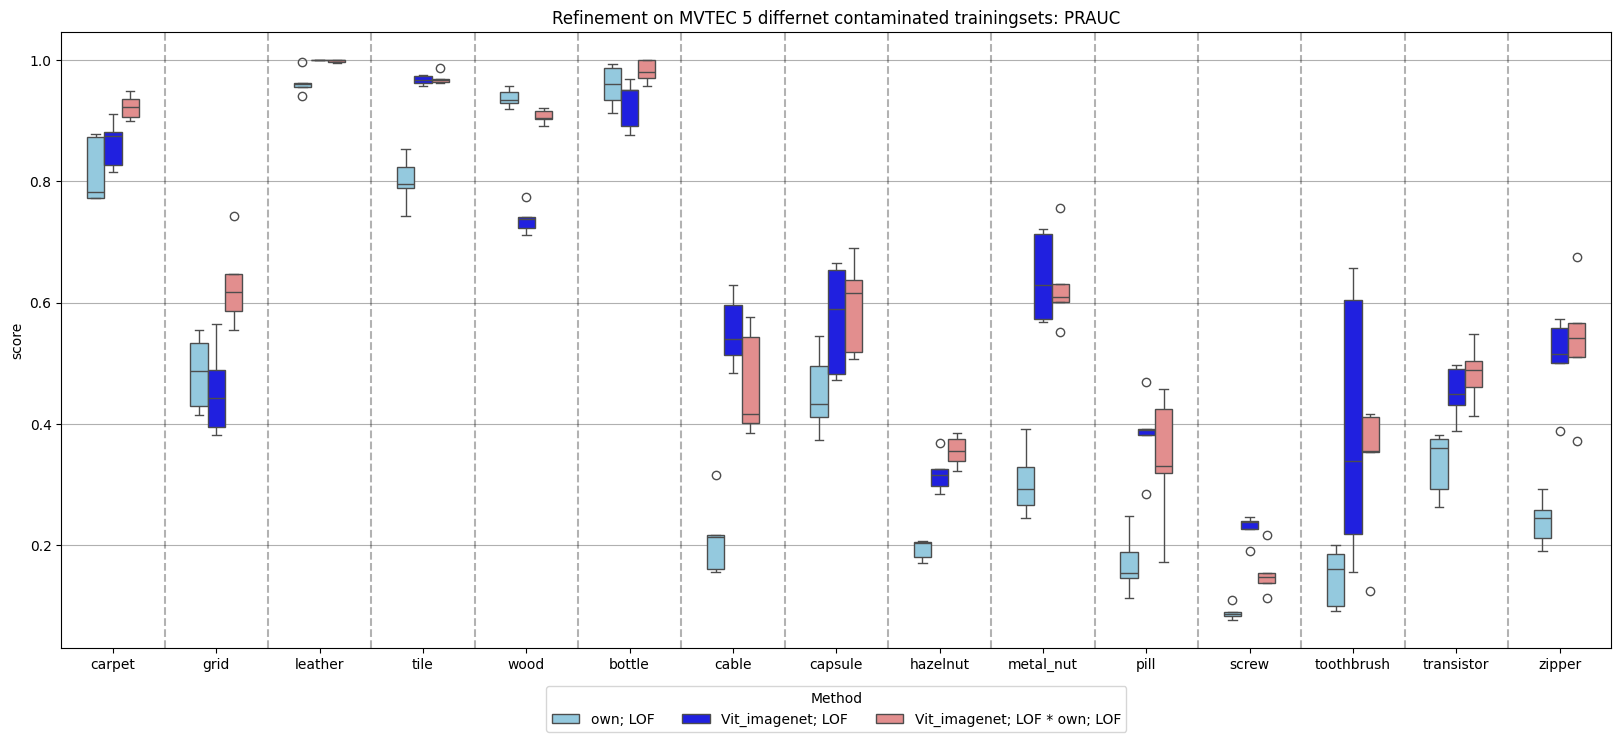

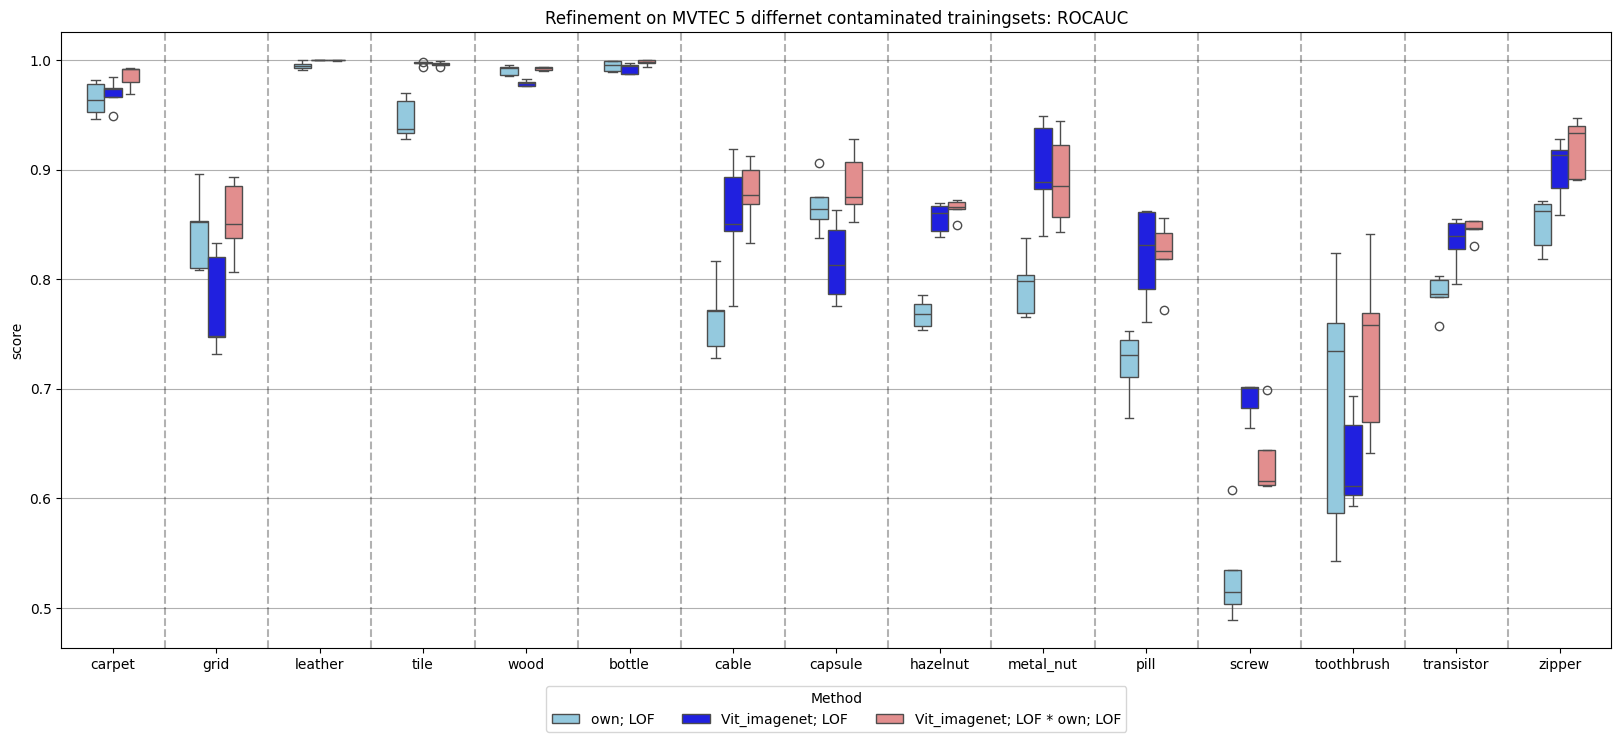

In [13]:

import pandas as pd
import seaborn as sns
import pickle
anocats={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]}


resdf=[]


for category in list(anocats.keys()):
    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_{category}.pkl'

    with open(file_path, 'rb') as file:
        input_= pickle.load(file)


    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_{category}.pkl'
    with open(file_path, 'rb') as file:
        input_sota= pickle.load(file)
        
        
        
    input_['Vit_beans; Cosine']=input_sota['Vit_beans; Cosine']

    input_["Vit_beans; LOF"]=input_sota["Vit_beans; LOF"]


    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_imagenet_{category}.pkl'
    with open(file_path, 'rb') as file:
        input_sota_im= pickle.load(file)
    input_['Vit_imagenet; Cosine']=input_sota_im['Vit_imagenet; Cosine']
    input_["Vit_imagenet; LOF"]=input_sota_im["Vit_imagenet; LOF"]
    
    
    
    ######### calculate combination

    scaler = MinMaxScaler()
    combination_list=[]
    
    for i in range(len(input_['Vit_imagenet; LOF'])):
        
        scores1=input_['Vit_imagenet; LOF'][i]
        score2=np.array(input_['own; LOF'][i])
        scores2 = scaler.fit_transform(score2.reshape(-1, 1)).flatten()
        scores2=np.array(1 - scores2)
        combination_list.append(scores1*scores2)

    input_["Vit_imagenet; LOF * own; LOF"] = combination_list
        
    
    res=pd.DataFrame(PR_ROC__stats(input_, category=category))
    resdf.append(res)

resdf=pd.concat(resdf)


print(resdf.head())

metrics_to_remove = ['own; ISO','TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_imagenet; Cosine', 'Vit_beans; Cosine',  'Vit_beans; LOF']
resdf = resdf[~resdf['method'].isin(metrics_to_remove)]

category_order = ['carpet', 'grid', 'leather','tile', 'wood','bottle', 'cable', 'capsule','hazelnut', 'metal_nut', 'pill', 'screw',    'toothbrush', 'transistor' ,'zipper']
resdf['category'] = pd.Categorical(resdf['category'], categories=category_order, ordered=True)



print(resdf.info())
order = [ 'own; LOF','Vit_imagenet; LOF',"Vit_imagenet; LOF * own; LOF"]






colors = ['skyblue', 'blue', 'lightcoral', 'red', 'purple', 'thistle', 'lightgreen', 'green', 'navy', 'lightgray', 'gray', 'deeppink', 'peachpuff', 'orange', 'lightolive', 'darkolivegreen', 'palegreen', 'limegreen', 'powderblue', 'teal', 'lightsteelblue', 'navy']
# palette = dict(zip(order, colors))
# Create a palette dictionary
palette = dict(zip(order, colors))
# plt.figure(figsize=(30, 8))
# plt.grid(True)
# sns.boxplot(x="method", y="score", hue="category", data=resdf[resdf['metric']=='PRAUC' ],order=order)
# plt.title('all categories')
# plt.show()

# plt.figure(figsize=(30, 8))
# plt.grid(True)
# sns.boxplot(x="method", y="score", hue="category", data=resdf[resdf['metric']=='PRAUC' ],order=order)
# plt.title('all categories')
# plt.show()



import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.grid(True)
sns.boxplot(x="category", y="score", hue="method", data=resdf[resdf['metric'] == 'PRAUC'], hue_order=order, palette=palette, width=0.5)
plt.title('Refinement on MVTEC 5 differnet contaminated trainingsets: PRAUC')
plt.xlabel('')

# Add vertical lines
for i in range(len(resdf['category'].unique()) - 1):
    plt.axvline(x=i + 0.5, color='black', alpha=0.3,linestyle='--')

# Place legend below the plot
plt.legend(title='Method', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=len(order))
plt.show()

# Plot for ROCAUC
plt.figure(figsize=(20, 8))
plt.grid(True)
sns.boxplot(x="category", y="score", hue="method", data=resdf[resdf['metric'] == 'ROCAUC'], hue_order=order, palette=palette, width=0.5)
plt.title('Refinement on MVTEC 5 differnet contaminated trainingsets: ROCAUC')
plt.xlabel('')

# Add vertical lines
for i in range(len(resdf['category'].unique()) - 1):
    plt.axvline(x=i + 0.5, color='black', alpha=0.3,linestyle='--')

# Place legend below the plot
plt.legend(title='Method', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=len(order))
plt.show()

['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_beans; LOF', 'Vit_beans; Cosine', 'Vit_imagenet; Cosine', 'Vit_imagenet; LOF', 'Vit_imagenet; LOF * own; LOF']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF
FMAPS; ISO
Vit_beans; LOF
Vit_beans; Cosine
Vit_imagenet; Cosine
Vit_imagenet; LOF
Vit_imagenet; LOF * own; LOF
['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_beans; LOF', 'Vit_beans; Cosine', 'Vit_imagenet; Cosine', 'Vit_imagenet; LOF', 'Vit_imagenet; LOF * own; LOF']
own; ISO
own; LOF
TSNE; ISO
TSNE; LOF
PCA; ISO
PCA; LOF
Original; ISO
Original; LOF
FMAPS; ISO
Vit_beans; LOF
Vit_beans; Cosine
Vit_imagenet; Cosine
Vit_imagenet; LOF
Vit_imagenet; LOF * own; LOF
['own; ISO', 'own; LOF', 'TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_be

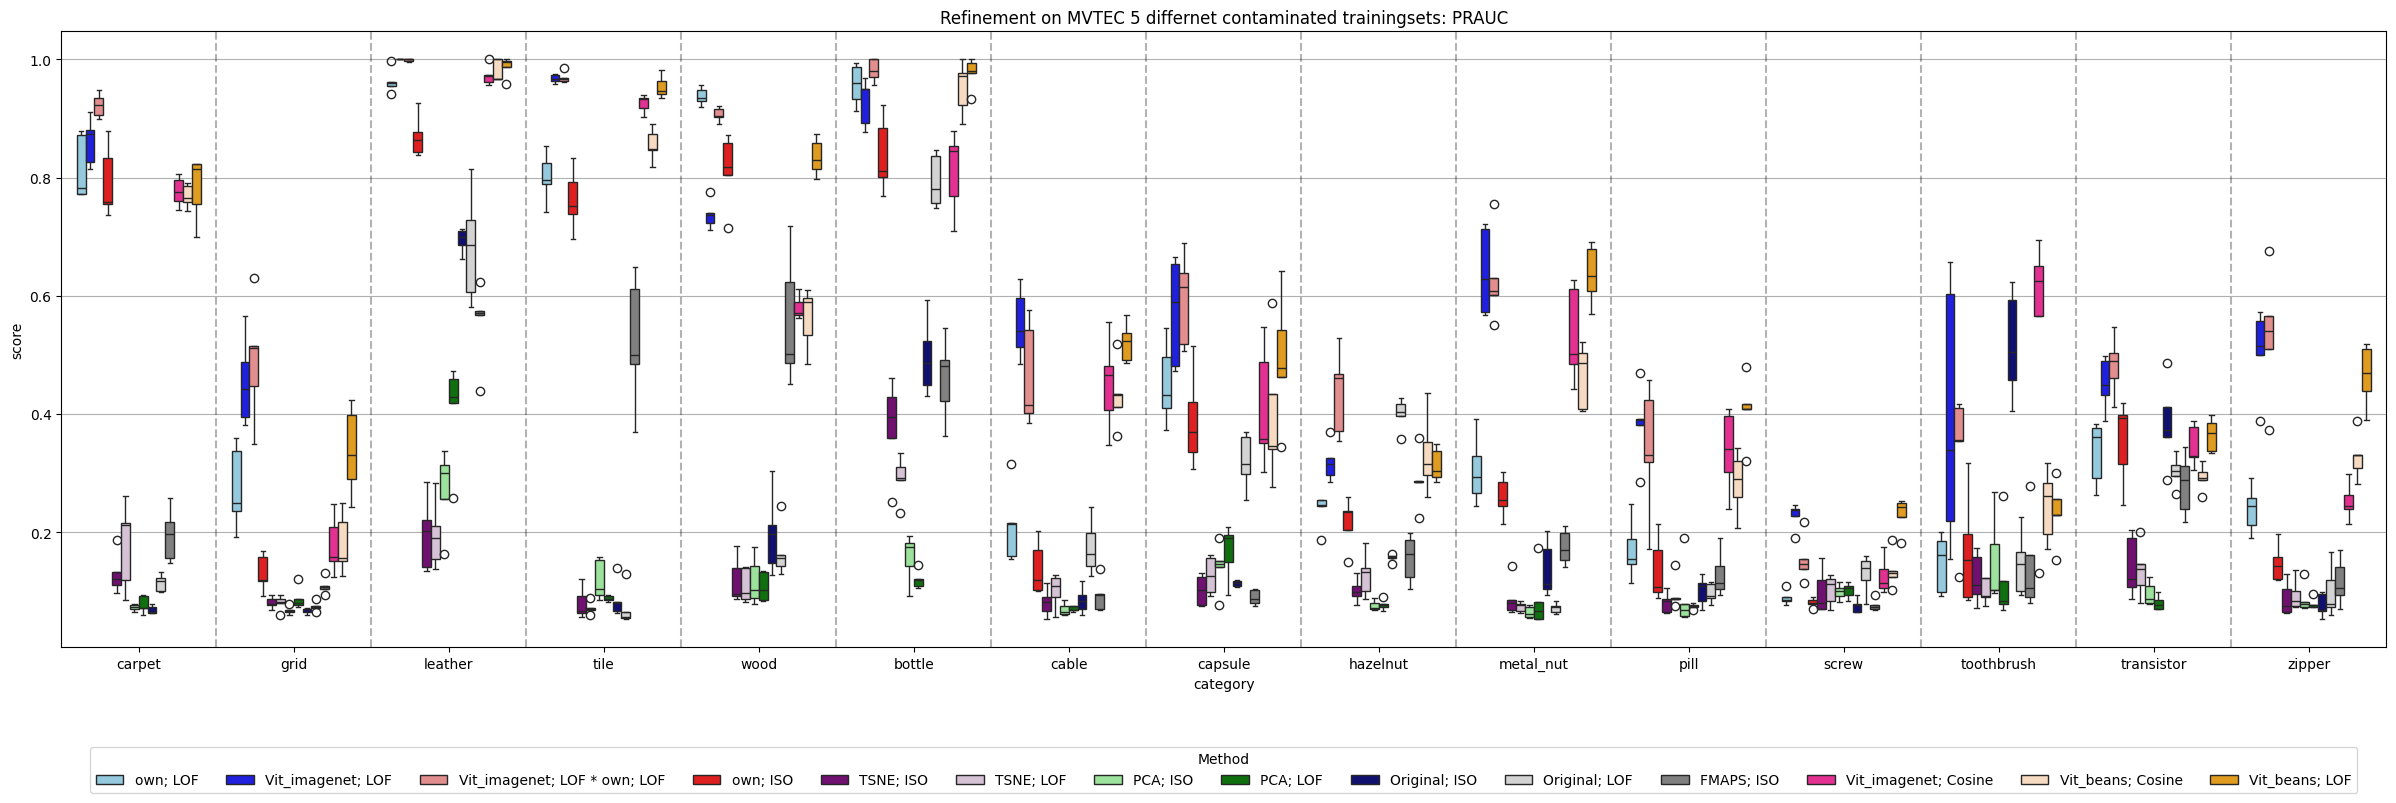

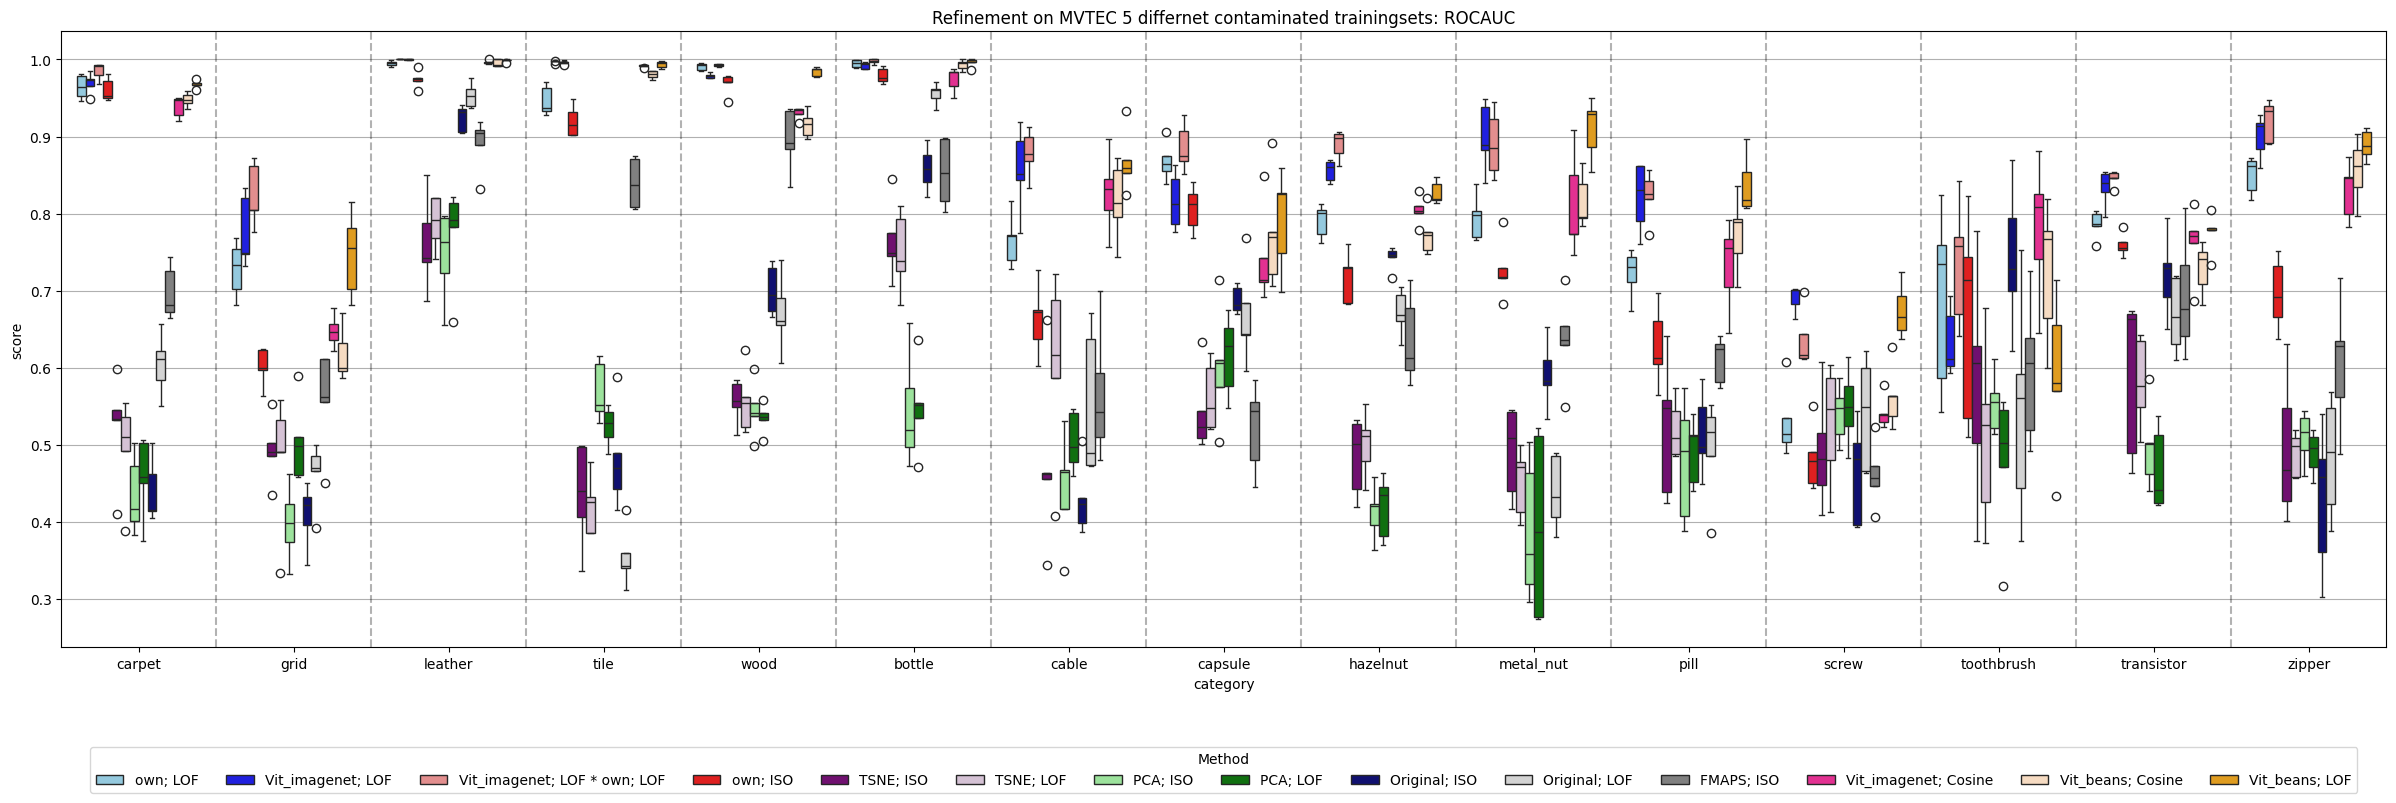

In [9]:

import pandas as pd
import seaborn as sns
import pickle
anocats={
    "bottle": ["broken_large", "broken_small", "contamination"],
    "cable": ["bent_wire", "cable_swap", "combined", "cut_inner_insulation", "cut_outer_insulation", "missing_cable", "missing_wire", "poke_insulation"],
    "capsule": ["crack", "faulty_imprint", "poke", "scratch","squeeze"],
    "carpet": ["color", "cut", "hole", "metal_contamination", "thread"],
    "grid": ["bent", "broken", "glue", "metal_contamination", "thread"],
    "hazelnut": ["crack", "cut", "hole", "print"],
    "leather": ["color", "cut", "fold", "glue", "poke"],
    "metal_nut": ["bent", "color", "flip", "scratch"],
    "pill": ["color", "combined","contamination", "crack", "faulty_imprint", "pill_type","scratch"],
    "screw": ["manipulated_front", "scratch_head", "scratch_neck","thread_side", "thread_top"],
    "tile": ["crack", "glue_strip", "gray_stroke", "oil","rough"],
    "toothbrush": ["defective"],
    "transistor": ["bent_lead", "cut_lead", "damaged_case", "misplaced"],
    "wood": ["color", "combined", "hole", "liquid", "scratch"],
    "zipper": ["broken_teeth", "combined","fabric_border", "fabric_interior","split_teeth","rough", "squeezed_teeth"]}


resdf=[]


for category in list(anocats.keys()):
    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_{category}.pkl'

    with open(file_path, 'rb') as file:
        input_= pickle.load(file)


    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_{category}.pkl'
    with open(file_path, 'rb') as file:
        input_sota= pickle.load(file)
        
        
        
    input_['Vit_beans; Cosine']=input_sota['Vit_beans; Cosine']

    input_["Vit_beans; LOF"]=input_sota["Vit_beans; LOF"]


    file_path = f'/home/bule/projects/UTRAD/results/refinement/Refinement_Comparison_SOTA_imagenet_{category}.pkl'
    with open(file_path, 'rb') as file:
        input_sota_im= pickle.load(file)
    input_['Vit_imagenet; Cosine']=input_sota_im['Vit_imagenet; Cosine']
    input_["Vit_imagenet; LOF"]=input_sota_im["Vit_imagenet; LOF"]
    
    
    
    ######### calculate combination

    scaler = MinMaxScaler()
    combination_list=[]
    
    for i in range(len(input_['Vit_imagenet; LOF'])):
        
        scores1=input_['Vit_imagenet; LOF'][i]
        score2=np.array(input_['own; LOF'][i])
        scores2 = scaler.fit_transform(score2.reshape(-1, 1)).flatten()
        scores2=np.array(1 - scores2)
        combination_list.append(scores1*scores2)

    input_["Vit_imagenet; LOF * own; LOF"] = combination_list
        
    
    res=pd.DataFrame(PR_ROC__stats(input_, category=category))
    resdf.append(res)

resdf=pd.concat(resdf)

category_order = ['carpet', 'grid', 'leather','tile', 'wood','bottle', 'cable', 'capsule','hazelnut', 'metal_nut', 'pill', 'screw',    'toothbrush', 'transistor' ,'zipper']
resdf['category'] = pd.Categorical(resdf['category'], categories=category_order, ordered=True)
print(resdf.head())

# metrics_to_remove = ['own; ISO','TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_imagenet; Cosine', 'Vit_beans; Cosine',  'Vit_beans; LOF']
# resdf = resdf[~resdf['method'].isin(metrics_to_remove)]

print(resdf.info())
order = [ 'own; LOF','Vit_imagenet; LOF',"Vit_imagenet; LOF * own; LOF",'own; ISO','TSNE; ISO', 'TSNE; LOF', 'PCA; ISO', 'PCA; LOF', 'Original; ISO', 'Original; LOF', 'FMAPS; ISO', 'Vit_imagenet; Cosine', 'Vit_beans; Cosine',  'Vit_beans; LOF']


colors = ['skyblue', 'blue', 'lightcoral', 'red', 'purple', 'thistle', 'lightgreen', 'green', 'navy', 'lightgray', 'gray', 'deeppink', 'peachpuff', 'orange', 'lightolive', 'darkolivegreen', 'palegreen', 'limegreen', 'powderblue', 'teal', 'lightsteelblue', 'navy']

# # Create a palette dictionary
palette = dict(zip(order, colors))
# plt.figure(figsize=(30, 8))
# plt.grid(True)
# sns.boxplot(x="method", y="score", hue="category", data=resdf[resdf['metric']=='PRAUC' ],order=order)
# plt.title('all categories')
# plt.show()

# plt.figure(figsize=(30, 8))
# plt.grid(True)
# sns.boxplot(x="method", y="score", hue="category", data=resdf[resdf['metric']=='PRAUC' ],order=order)
# plt.title('all categories')
# plt.show()


import matplotlib.pyplot as plt
plt.figure(figsize=(30, 8))
plt.grid(True)
sns.boxplot(x="category", y="score", hue="method", data=resdf[resdf['metric'] == 'PRAUC'], hue_order=order, palette=palette)
plt.title('Refinement on MVTEC 5 differnet contaminated trainingsets: PRAUC')

# Add vertical lines
for i in range(len(resdf['category'].unique()) - 1):
    plt.axvline(x=i + 0.5, color='black', alpha=0.3,linestyle='--')

# Place legend below the plot
plt.legend(title='Method', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(order))
plt.show()

# Plot for ROCAUC
plt.figure(figsize=(30, 8))
plt.grid(True)
sns.boxplot(x="category", y="score", hue="method", data=resdf[resdf['metric'] == 'ROCAUC'], hue_order=order, palette=palette)
plt.title('Refinement on MVTEC 5 differnet contaminated trainingsets: ROCAUC')

# Add vertical lines
for i in range(len(resdf['category'].unique()) - 1):
    plt.axvline(x=i + 0.5, color='black', alpha=0.3,linestyle='--')

# Place legend below the plot
plt.legend(title='Method', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(order))
plt.show()

/tmp/ipykernel_2577823/2371411609.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


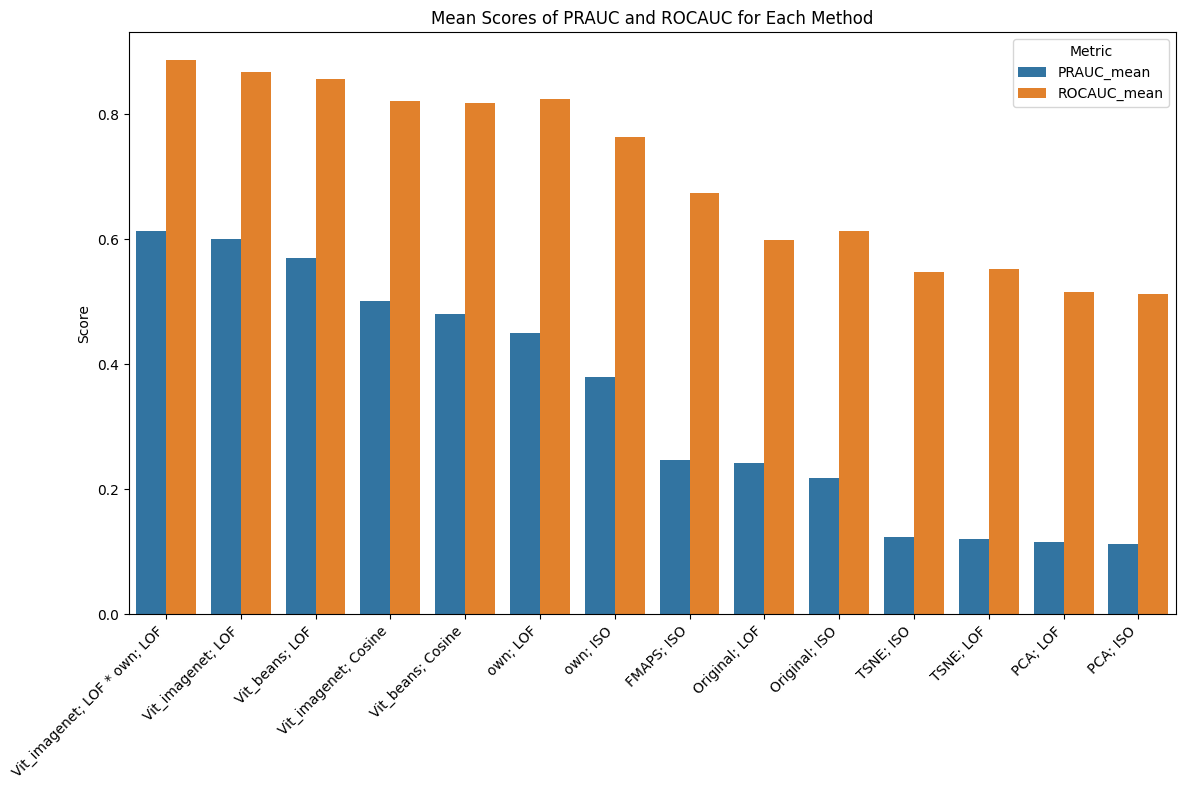

In [6]:
prcmeans=resdf[resdf['metric'] == 'PRAUC'].drop(columns=['metric']).groupby(['method'])['score'].mean().reset_index()
aurocmeans=resdf[resdf['metric'] == 'ROCAUC'].drop(columns=['metric']).groupby(['method'])['score'].mean().reset_index()



prcmeans = prcmeans.rename(columns={'score': 'PRAUC_mean'})
aurocmeans = aurocmeans.rename(columns={'score': 'ROCAUC_mean'})

# Join the DataFrames on 'method'
combinedmeans = pd.merge(prcmeans, aurocmeans, on='method')
combinedmeans = combinedmeans.sort_values(by='PRAUC_mean', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Melt the DataFrame to have a suitable format for seaborn
combinedmeans_melted = combinedmeans.melt(id_vars='method', value_vars=['PRAUC_mean', 'ROCAUC_mean'], var_name='Metric', value_name='Score')

# Create a bar plot
sns.barplot(data=combinedmeans_melted, x='method', y='Score', hue='Metric', ax=ax)

# Set plot labels and title
ax.set_title('Mean Scores of PRAUC and ROCAUC for Each Method')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('')
# Display the plot
plt.tight_layout()
plt.show()